In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
SECURITY_DUMMY = '----------------'
erm2_nwe9_creds = {
    'IAM_SERVICE_ID'    : SECURITY_DUMMY,
    'IBM_API_KEY_ID'    : SECURITY_DUMMY,
    'ENDPOINT'          : 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT' : 'https://iam.eu-gb.bluemix.net/oidc/token',
    'BUCKET'            : SECURITY_DUMMY,
    'FILE'              : 'erm2_nwe9.csv'
}

# Here we check if the credentials are present, if not try 
# load the local file if they are then read from the cloud.
if erm2_nwe9_creds.get('IAM_SERVICE_ID') == SECURITY_DUMMY :
    # This is the alternative to get the code run locally with a local csv file
    body = 'data' + os.path.sep + 'erm2_nwe9.csv'
else :
    # The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
    # You might want to remove those credentials before you share the notebook.
    client = ibm_boto3.client(
        service_name = 's3',
        ibm_api_key_id = erm2_nwe9_creds.get('IBM_API_KEY_ID'),
        ibm_auth_endpoint = erm2_nwe9_creds.get('IBM_AUTH_ENDPOINT'),
        config = Config(signature_version='oauth'),
        endpoint_url = erm2_nwe9_creds.get('ENDPOINT'))
    
    #Read the body from the client
    body = client.get_object(
        Bucket = erm2_nwe9_creds.get('BUCKET'),
        Key = erm2_nwe9_creds.get('FILE'))['Body']
    
    # add missing __iter__ method, so pandas accepts body as file-like object
    def __iter__(self): return 0
    if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
        
print(body)

data/erm2_nwe9.csv


In [3]:
# Read the CSV file
dhp_df = pd.read_csv(body, parse_dates = True)
dhp_df.head()

,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,location_type,status,closed_date
0,2020-02-15T15:16:35.000,45623186,HEAT/HOT WATER,10014.0,345 6 AVENUE,6 AVENUE,ADDRESS,NEW YORK,The following complaint conditions are still o...,MANHATTAN,40.731844,-74.000870,RESIDENTIAL BUILDING,Open,NaN
1,2020-02-15T11:42:07.000,45623364,HEAT/HOT WATER,11233.0,1610 ST JOHNS PLACE,ST JOHNS PLACE,ADDRESS,BROOKLYN,The complaint you filed is a duplicate of a co...,BROOKLYN,40.670215,-73.924414,RESIDENTIAL BUILDING,Open,NaN
2,2020-02-15T12:04:58.000,45626851,HEAT/HOT WATER,10468.0,2405 GRAND AVENUE,GRAND AVENUE,ADDRESS,BRONX,The complaint you filed is a duplicate of a co...,BRONX,40.862140,-73.903806,RESIDENTIAL BUILDING,Open,NaN
3,2020-02-15T07:49:50.000,45623804,DOOR/WINDOW,11694.0,106-10 SHORE FRONT PARKWAY,SHORE FRONT PARKWAY,ADDRESS,Rockaway Park,The following complaint conditions are still o...,QUEENS,40.580979,-73.825831,RESIDENTIAL BUILDING,Open,NaN
4,2020-02-15T11:03:15.000,45625231,HEAT/HOT WATER,11213.0,1587 CARROLL STREET,CARROLL STREET,ADDRESS,BROOKLYN,The following complaint conditions are still o...,BROOKLYN,40.666263,-73.933725,RESIDENTIAL BUILDING,Open,NaN


In [4]:
# Investigate the dolumn types, the created_date is an object and needs conversion
dhp_df.dtypes

created_date               object
unique_key                  int64
complaint_type             object
incident_zip              float64
incident_address           object
street_name                object
address_type               object
city                       object
resolution_description     object
borough                    object
latitude                  float64
longitude                 float64
location_type              object
status                     object
closed_date                object
dtype: object

In [5]:
# Convert the date string to the date type
dhp_df['created_date'] = dhp_df['created_date'].astype('datetime64[ns]')
display(dhp_df.dtypes)

dhp_df.head()

created_date              datetime64[ns]
unique_key                         int64
complaint_type                    object
incident_zip                     float64
incident_address                  object
street_name                       object
address_type                      object
city                              object
resolution_description            object
borough                           object
latitude                         float64
longitude                        float64
location_type                     object
status                            object
closed_date                       object
dtype: object

,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,location_type,status,closed_date
0,2020-02-15 15:16:35,45623186,HEAT/HOT WATER,10014.0,345 6 AVENUE,6 AVENUE,ADDRESS,NEW YORK,The following complaint conditions are still o...,MANHATTAN,40.731844,-74.000870,RESIDENTIAL BUILDING,Open,NaN
1,2020-02-15 11:42:07,45623364,HEAT/HOT WATER,11233.0,1610 ST JOHNS PLACE,ST JOHNS PLACE,ADDRESS,BROOKLYN,The complaint you filed is a duplicate of a co...,BROOKLYN,40.670215,-73.924414,RESIDENTIAL BUILDING,Open,NaN
2,2020-02-15 12:04:58,45626851,HEAT/HOT WATER,10468.0,2405 GRAND AVENUE,GRAND AVENUE,ADDRESS,BRONX,The complaint you filed is a duplicate of a co...,BRONX,40.862140,-73.903806,RESIDENTIAL BUILDING,Open,NaN
3,2020-02-15 07:49:50,45623804,DOOR/WINDOW,11694.0,106-10 SHORE FRONT PARKWAY,SHORE FRONT PARKWAY,ADDRESS,Rockaway Park,The following complaint conditions are still o...,QUEENS,40.580979,-73.825831,RESIDENTIAL BUILDING,Open,NaN
4,2020-02-15 11:03:15,45625231,HEAT/HOT WATER,11213.0,1587 CARROLL STREET,CARROLL STREET,ADDRESS,BROOKLYN,The following complaint conditions are still o...,BROOKLYN,40.666263,-73.933725,RESIDENTIAL BUILDING,Open,NaN


In [6]:
# Now we can select the list of complains created before the 31st Dec 2018
max_date = np.datetime64('2018-12-31')
sel_comp_df = dhp_df[dhp_df['created_date'] <= max_date][['complaint_type']]
sel_comp_df.head()

,complaint_type
52166,PAINT/PLASTER
52167,FLOORING/STAIRS
52168,APPLIANCE
52169,UNSANITARY CONDITION
52170,PAINT/PLASTER


In [7]:
# Let's produce the table form of the complains summary
summary = sel_comp_df.groupby('complaint_type').size().to_frame()
summary.columns = ['count']
display(summary.sort_values(by = 'count', axis=0, ascending = False))

,count
complaint_type,
HEAT/HOT WATER,1023062
HEATING,887869
PLUMBING,673260
GENERAL CONSTRUCTION,500863
UNSANITARY CONDITION,390705
PAINT - PLASTER,361257
PAINT/PLASTER,310888
ELECTRIC,289280
NONCONST,260890


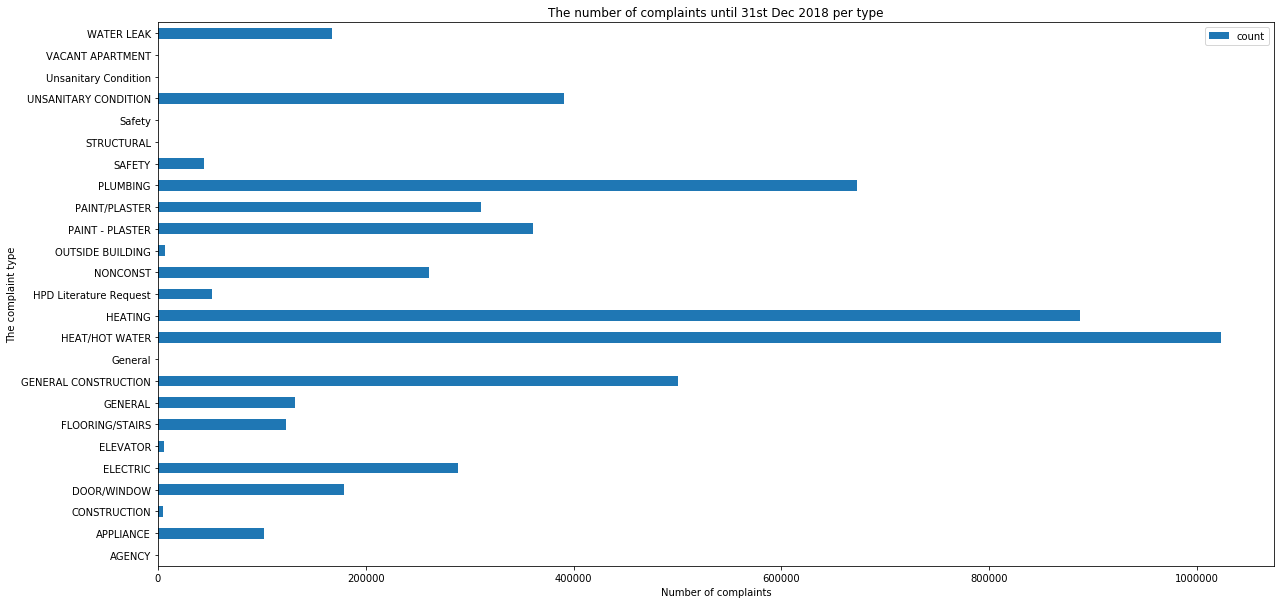

In [8]:
# Let us look at the distribution of the complaint type values
summary.plot(kind = "barh",
             figsize = (20,10))
plt.title('The number of complaints until 31st Dec 2018 per type')
plt.xlabel('Number of complaints')
plt.ylabel('The complaint type')
plt.show()
plt.close()

In [9]:
# QUESTION:
#   What Is the Top Complaint Type?
#
# ANSWER:
#   According to the Table statistics and the presented Bar chart  
#   the top complaint type is the HEAT/HOT WATER complaint which
#   counts to 1023062 complaints until the 31st of December 2018.
#   The next in the list is the the HEATING complaint which
#   counts to 887869 occasions and thus has to be handled as
#   a second priority item.